[[ 1.      0.      0.      0.      0.      0.      0.      0.    ]
 [ 1.     -1.      0.      0.      0.      0.      0.      0.    ]
 [ 0.      1.     -1.      0.      0.      0.      0.      0.    ]
 [ 0.      0.      1.     -1.      0.      0.      0.      0.    ]
 [-0.      0.      0.      0.      1.     -1.      0.      0.    ]
 [ 0.     -0.      0.0109  0.      0.      1.     -1.      0.    ]
 [ 0.      0.     -0.009   0.      0.      0.      1.     -1.    ]
 [ 0.      0.      0.     -0.      0.      0.      0.      1.    ]]
[  0.     -42.1263  58.8376 112.9451  -0.       0.       0.0001  -0.0001]
7
4
-4.406470611843091e-06
-8.146551724137925e-05


C:\Users\20241868\AppData\Local\Temp\ipykernel_10848\993854942.py:75: RuntimeWarning: divide by zero encountered in log
  Az_loc = A_0[k] - (Jz[k] * (r_loc**2) / 4 - c[k] * np.log(r_loc)) / nu[k]
C:\Users\20241868\AppData\Local\Temp\ipykernel_10848\993854942.py:75: RuntimeWarning: invalid value encountered in multiply
  Az_loc = A_0[k] - (Jz[k] * (r_loc**2) / 4 - c[k] * np.log(r_loc)) / nu[k]
C:\Users\20241868\AppData\Local\Temp\ipykernel_10848\993854942.py:76: RuntimeWarning: invalid value encountered in divide
  H_theta_loc = Jz[k] * r_loc / 2 - c[k] / r_loc


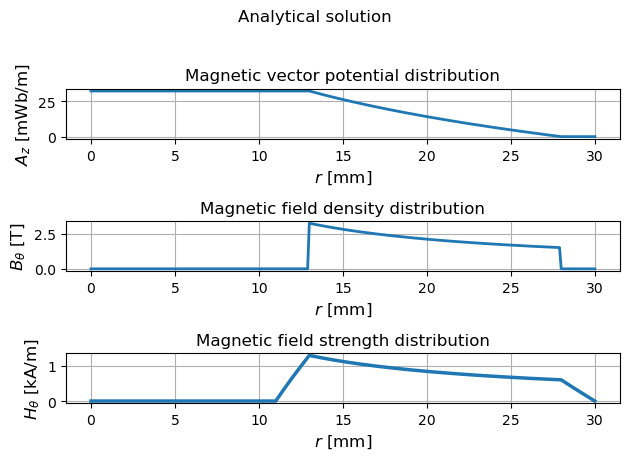

In [12]:
import numpy as np
import matplotlib.pyplot as plt
np.set_printoptions(precision=4, suppress=True)

# Parameters
MMF_i = 105                     # Imposed MMF = N*i
l = np.array([11, 2, 15, 2]) * 1e-3   # Region thickness in [m]
# l = np.array([5.3, 1, 5, 1]) * 1e-3   # Region thickness in [m]
mu_r = np.array([1, 1, 2000, 1])      # Relative permeability of each domain
MMF = np.array([0, MMF_i, 0, -MMF_i]) # MMF in each domain

dr = 10e-5              # Resolution of r for plots in [m]

# Boundary conditions
A_0free = 0            # Dirichlet BC: Az(r=rho_4) = Afree

# Calculation variables
mu_0 = np.pi * 4e-7    # Permeability of vacuum
mu = mu_0 * mu_r       # Magnetic permeability of each domain

rho0 = np.concatenate(([0], np.cumsum(l)))  # Radii of boundaries including origin

Jz = MMF / (np.pi * (rho0[1:]**2 - rho0[:-1]**2))  # Current density in each domain
# print(Jz)

# Analytical solution
rho = rho0[1:]      # Radii of domain interfaces only
N_dom = len(rho)    # Number of domains
nu = 1 / mu         # Inverse of permeability of each domain

# Matrix construction
M = np.zeros((2 * N_dom, 2 * N_dom))     # 2*Ndom unknowns to be solved (c_k and A_(0,k))
y = np.zeros(2 * N_dom)

M[0, 0] = 1            # Finite requirement of the field at r=0

for k in range(N_dom - 1):
    # Continuity of circumferential H at r=rho (solve for c_k)
    M[k + 1, k] = 1
    M[k + 1, k + 1] = -1
    y[k + 1] = (rho[k]**2) * (Jz[k] - Jz[k + 1]) / 2

    # Continuity of Az at r=rho (solve for A_{0,k})
    M[k + N_dom, k] = np.log(rho[k]) / nu[k]
    M[k + N_dom, k + 1] = -np.log(rho[k]) / nu[k + 1]
    M[k + N_dom, k + N_dom] = 1
    M[k + N_dom, k + N_dom + 1] = -1
    y[k + N_dom] = (rho[k]**2) * (Jz[k] / nu[k] - Jz[k + 1] / nu[k + 1]) / 4

# Free choice for Az: Az(rho(Ndom)) = Afree
M[2 * N_dom - 1, N_dom - 1] = np.log(rho[N_dom - 1]) / nu[N_dom - 1]
M[2 * N_dom - 1, 2 * N_dom - 1] = 1
y[2 * N_dom - 1] = A_0free + (Jz[N_dom - 1] * rho[N_dom - 1]**2) / (4 * nu[N_dom - 1])

print(M)
print(y)
print(2 * N_dom - 1)
print(N_dom)
print(np.log(rho[N_dom - 1]) / nu[N_dom - 1])
print(y[2 * N_dom - 1])
# Solving the system of equations
x = np.linalg.solve(M, y)

c = x[:N_dom]
A_0 = x[N_dom:]

# Calculation of Az, B and H in the domain
r = []
Az = []
H_theta = []
B_theta = []

for k in range(N_dom):
    r_loc = np.arange(rho0[k], rho0[k + 1], dr)
    Az_loc = A_0[k] - (Jz[k] * (r_loc**2) / 4 - c[k] * np.log(r_loc)) / nu[k]
    H_theta_loc = Jz[k] * r_loc / 2 - c[k] / r_loc

    # Special case to prevent NaN after division by 0
    isr0 = (r_loc == 0)
    if np.any(isr0):
        Az_loc[isr0] = A_0[k]
        H_theta_loc[isr0] = 0

    r.extend(r_loc)
    Az.extend(Az_loc)
    H_theta.extend(H_theta_loc)
    B_theta.extend(H_theta_loc / nu[k])

# Plotting
plt.figure()
plt.suptitle('Analytical solution')

# Magnetic vector potential
plt.subplot(3, 1, 1)
plt.plot(np.array(r) * 1e3, np.array(Az) * 1e3, linewidth=2)
plt.grid(True)
plt.xlabel('$r$ [mm]', fontsize=12)
plt.ylabel('$A_z$ [mWb/m]', fontsize=12)
plt.title('Magnetic vector potential distribution')

# Magnetic field density B
plt.subplot(3, 1, 2)
plt.plot(np.array(r) * 1e3, B_theta, linewidth=2)
plt.grid(True)
plt.xlabel('$r$ [mm]', fontsize=12)
plt.ylabel('$B_{\\theta}$ [T]', fontsize=12)
plt.title('Magnetic field density distribution')

# Magnetic field strength H
plt.subplot(3, 1, 3)
plt.plot(np.array(r) * 1e3, np.array(H_theta) / 1e3, linewidth=2.5)
plt.grid(True)
plt.xlabel('$r$ [mm]', fontsize=12)
plt.ylabel('$H_{\\theta}$ [kA/m]', fontsize=12)
plt.title('Magnetic field strength distribution')

plt.tight_layout(rect=[0, 0.03, 1, 0.95])
plt.show()


In [13]:
Az[0]

0.03222711406829048